# TP FINAL DSS sobre el Titanic - Modelo: Regresión Logística

**Objetivo:** predecir la probabilidad de supervivencia de un pasajero del Titanic. Se realiza el preprocesamiento, modelo y evaluación


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc,
    classification_report, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

train_path = "train.csv"

df = pd.read_csv(train_path)
print("Dataset shape:", df.shape)

Dataset shape: (891, 12)


## Preprocesamiento
Se tomaron las siguientes decisiones:
- Eliminar: PassengerId, Name, Ticket y Cabin (Cabin tiene muchos nulos).
- Imputar Age con mediana.
- Imputar Embarked con la moda.
- Codificar Sex (male=1, female=0).
- One-hot Embarked (drop_first=True).
- Escalar: Age, SibSp, Parch, Fare, Pclass.
- 
Se justifica cada paso en el informe(cuando haya uno)


In [14]:
# Copia y preprocesamiento
df_proc = df.drop(columns=['PassengerId','Name','Ticket','Cabin'])

# Imputaciones
df_proc['Age'] = df_proc['Age'].fillna(df_proc['Age'].median())
df_proc['Embarked'] = df_proc['Embarked'].fillna(df_proc['Embarked'].mode()[0])

# Codificaciones
df_proc['Sex'] = df_proc['Sex'].map({'male':1, 'female':0})
df_proc = pd.get_dummies(df_proc, columns=['Embarked'], drop_first=True)

# guarda el dataset procesado
processed_csv = "titanic_procesado.csv"
df_proc.to_csv(processed_csv, index=False)
print("Procesado guardado en:", processed_csv)

df_proc.head()


Procesado guardado en: titanic_procesado.csv


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True


## Modelado: Regresión Logística
Pipeline:
- StandardScaler para variables numéricas.
- LogisticRegression (solver='liblinear').

Validación:
- Split train/test 80/20 (estratificado).
- GridSearchCV sobre C con StratifiedKFold (5 folds).
Métrica principal para CV: ROC-AUC.


In [15]:
# Features
X = df_proc.drop(columns=['Survived'])
y = df_proc['Survived']

# Train/test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# Pipeline y grid
numeric_features = ['Age','SibSp','Parch','Fare','Pclass']
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)],
    remainder='passthrough'
)

pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
])

param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1
)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor CV ROC-AUC:", grid.best_score_)


# Guarda el modelo
model = "model_reglogistica.pkl"
joblib.dump(best, model)

print("Modelo guardado en:", model)


# Metricas en entrenamiento
y_pred_train = best.predict(X_train)
y_prob_train = best.predict_proba(X_train)[:, 1]

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
roc_auc_train = roc_auc_score(y_train, y_prob_train)

print("\n=========== MÉTRICAS TRAIN ===========")
print(f"Accuracy (train): {acc_train:.4f}")
print(f"Precision (train): {prec_train:.4f}")
print(f"Recall (train): {rec_train:.4f}")
print(f"F1-score (train): {f1_train:.4f}")
print(f"ROC-AUC (train): {roc_auc_train:.4f}")

# Predicciones y probabilidades
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:, 1]

Train/Test shapes: (712, 8) (179, 8)
Mejores hiperparámetros: {'clf__C': 10}
Mejor CV ROC-AUC: 0.8542613570395702
Modelo guardado en: model_reglogistica.pkl

=========== MÉTRICAS TRAIN ===========
Accuracy (train): 0.8062
Precision (train): 0.7668
Recall (train): 0.7106
F1-score (train): 0.7376
ROC-AUC (train): 0.8592


### Evaluación en test
Se calcula: accuracy, precision, recall, F1, ROC-AUC. Además se grafica la matriz de confusión y la curva ROC.



=========== MÉTRICAS TEST ===========
Accuracy: 0.8045
Precision: 0.7931
Recall: 0.6667
F1-score: 0.7244
ROC-AUC: 0.8437

 Reporte de Clasificación:
                   precision    recall  f1-score   support

No sobrevivió: 0     0.8099    0.8909    0.8485       110
   Sobrevivió: 1     0.7931    0.6667    0.7244        69

        accuracy                         0.8045       179
       macro avg     0.8015    0.7788    0.7864       179
    weighted avg     0.8034    0.8045    0.8007       179


============= ANÁLISIS DE OVERFITTING =============
ROC-AUC: Train = 0.8592 | Test = 0.8437
F1-score: Train = 0.7376     | Test = 0.7244
Accuracy: Train = 0.8062    | Test = 0.8045

==== No se detecta overfitting significativo ====
- Train y test están bastante alineados


<Figure size 640x480 with 0 Axes>

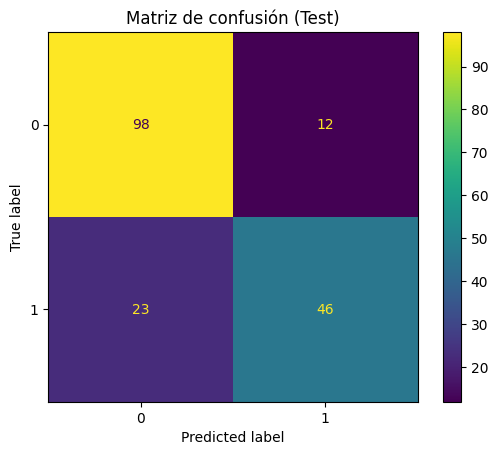

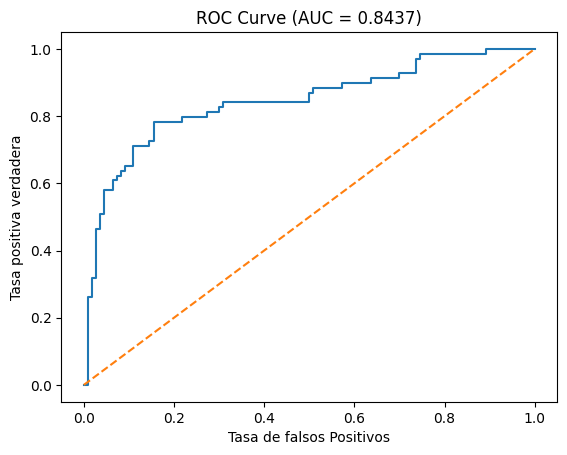

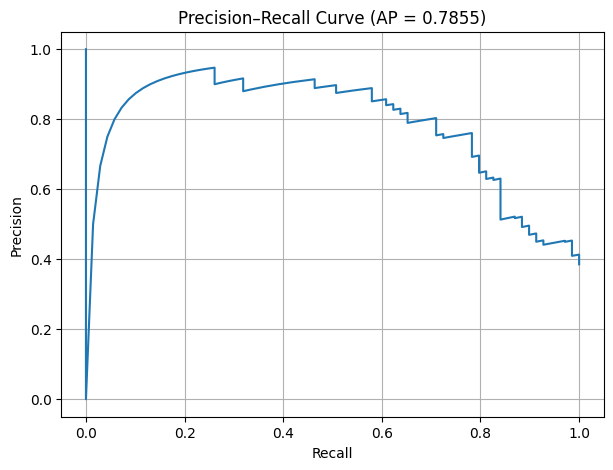

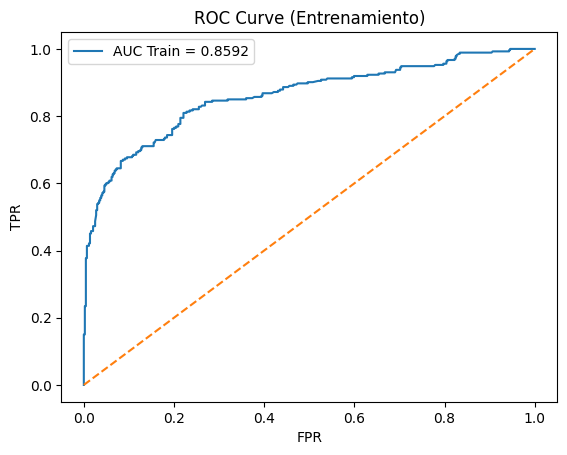

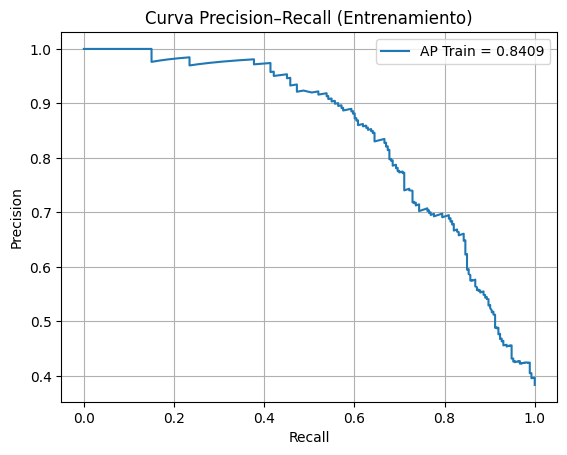

Métricas con threshold ajustado = 0.4
                  precision    recall  f1-score   support

No sobrevivió: 0     0.8585    0.8273    0.8426       110
   Sobrevivió: 1     0.7397    0.7826    0.7606        69

        accuracy                         0.8101       179
       macro avg     0.7991    0.8049    0.8016       179
    weighted avg     0.8127    0.8101    0.8110       179



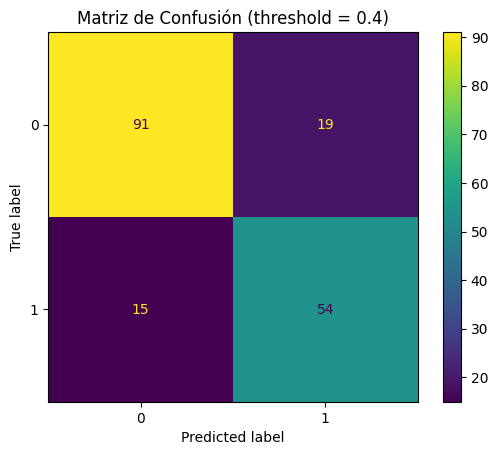

In [16]:
# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\n=========== MÉTRICAS TEST ===========")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
#print("\n Reporte de Clasificación:\n", classification_report(y_test, y_pred, digits=4))
print("\n Reporte de Clasificación:\n", 
      classification_report(
          y_test,
          y_pred,
          digits=4,
          target_names=['No sobrevivió: 0', 'Sobrevivió: 1']
      )
)

# Análisis de overfitting
print("\n============= ANÁLISIS DE OVERFITTING =============")

print(f"ROC-AUC: Train = {roc_auc_train:.4f} | Test = {roc_auc:.4f}")
print(f"F1-score: Train = {f1_train:.4f}     | Test = {f1:.4f}")
print(f"Accuracy: Train = {acc_train:.4f}    | Test = {acc:.4f}")

if (roc_auc_train - roc_auc) > 0.10 or (f1_train - f1) > 0.10:
    print("\n==== POSIBLE OVERFITTING DETECTADO ====")
    print("- El modelo rinde notablemente mejor en entrenamiento que en test")
    print("- Podría estar memorizando patrones del train")
else:
    print("\n==== No se detecta overfitting significativo ====")
    print("- Train y test están bastante alineados")


# Matriz de confusion (Test)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="viridis")
plt.title("Matriz de confusión (Test)")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.title(f"ROC Curve (AUC = {roc_auc_val:.4f})")
plt.xlabel("Tasa de falsos Positivos")
plt.ylabel("Tasa positiva verdadera")
plt.show()

# Curva precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

# Curva ROC (Train)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
roc_auc_train_curve = auc(fpr_train, tpr_train)

plt.figure()
plt.plot(fpr_train, tpr_train, label=f"AUC Train = {roc_auc_train_curve:.4f}")
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve (Entrenamiento)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Curva precision- recall (Train)
prec_train_curve, rec_train_curve, _ = precision_recall_curve(y_train, y_prob_train)
ap_train = average_precision_score(y_train, y_prob_train)

plt.figure()
plt.plot(rec_train_curve, prec_train_curve, label=f"AP Train = {ap_train:.4f}")
plt.title("Curva Precision–Recall (Entrenamiento)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# Threshold ajustado
threshold = 0.40
y_pred_adj = (y_prob >= threshold).astype(int)

print("Métricas con threshold ajustado =", threshold)
#print(classification_report(y_test, y_pred_adj, digits=4))
print(classification_report(
    y_test,
    y_pred_adj,
    digits=4,
    target_names=['No sobrevivió: 0', 'Sobrevivió: 1']
))

cm_adj = confusion_matrix(y_test, y_pred_adj)
disp_adj = ConfusionMatrixDisplay(confusion_matrix=cm_adj)
disp_adj.plot(cmap="viridis")
plt.title(f"Matriz de Confusión (threshold = {threshold})")
plt.show()

### Interpretación de coeficientes
La regresión logística permite ver coeficientes (efecto en log-odds) las variables con coeficiente positivo aumentan la probabilidad de supervivencia; negativas la disminuyen.Se calculan y ordenan los coeficientes.


In [17]:
# Features en el orden del pipeline
remainder_cols = [c for c in X.columns if c not in numeric_features]
feature_names = numeric_features + remainder_cols

coefs = best.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
coef_df = coef_df.sort_values(by='coefficient', ascending=False)
display(coef_df)

# Guarda coeficientes
coef_csv = "titanic_logreg_coeficientes.csv"
coef_df.to_csv(coef_csv, index=False)
print("Coeficientes guardados en:", coef_csv)


,feature,coefficient
6,Embarked_Q,0.315456
3,Fare,0.093573
2,Parch,-0.067982
1,SibSp,-0.267084
7,Embarked_S,-0.380980
0,Age,-0.514282
4,Pclass,-0.947576
5,Sex,-2.672891


Coeficientes guardados en: titanic_logreg_coeficientes.csv


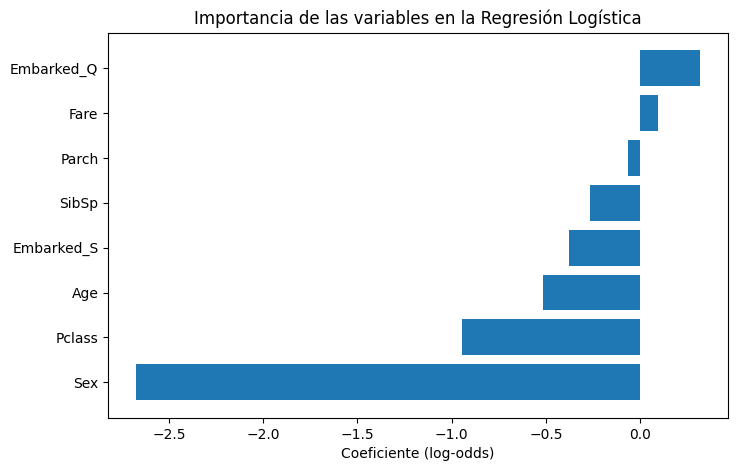

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

coef_df = pd.read_csv("titanic_logreg_coeficientes.csv")

plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.title("Importancia de las variables en la Regresión Logística")
plt.xlabel("Coeficiente (log-odds)")
plt.gca().invert_yaxis()
plt.show()
